In [1]:
random_seed = 42
import numpy as np; np.random.seed(random_seed)
import xgboost
from sklearn.metrics import mean_absolute_error
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy


class HyperParameterOptimizer(object):
    def __init__(self):
        self.model = None
        self.feature_importances_ = None
    
    def fit(self, _train_X, _train_y):
        print(f"Current shape of feature matrix:", _train_X.shape)
        num_boost_round = 99999

        def feval(preds, train_data):
            labels = train_data.get_label()
            return 'mae', mean_absolute_error(labels, preds)
        
        all_results = []
        for max_depth in [5]: # [5, 10, 15, 20, 25]
            for learning_rate in [0.01]:
                for colsample_bytree in [0.5]:
                    for min_child_weight in [6]: # 3, 6, 8, 12
                        train_X = deepcopy(_train_X)
                        train_y = deepcopy(_train_y)
                        dtrain = xgboost.DMatrix(train_X, label=train_y)
                        params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "min_child_weight": min_child_weight, "n_jobs": -1}
                        cv_results = xgboost.cv(
                            params,
                            dtrain,
                            num_boost_round=num_boost_round,
                            seed=random_seed,
                            nfold=10,
                            feval=feval,
                            early_stopping_rounds=20,
                            verbose_eval=False
                        )
                        print(train_X.shape[1], max_depth, learning_rate, colsample_bytree, min_child_weight, np.round(float(cv_results["test-mae-mean"].iloc[len(cv_results["test-mae-mean"])-1]), 4))
                        all_results.append((max_depth, learning_rate, colsample_bytree, min_child_weight, cv_results))
        all_results_df = pd.DataFrame(all_results, columns=["max_depth", "learning_rate", "colsample_bytree", "min_child_weight", "cv_results"])
        all_results_df["best_validation_f1"] = all_results_df["cv_results"].apply(lambda x: x.iloc[len(x)-1]["test-mae-mean"])
        all_results_df = all_results_df.sort_values(by="best_validation_f1", ascending=False).reset_index(drop=True)
        best_parameters = all_results_df.iloc[0]
        best_max_depth = int(best_parameters["max_depth"])
        best_learning_rate = float(best_parameters["learning_rate"])
        best_colsample_bytree = float(best_parameters["colsample_bytree"])
        best_min_child_weight = float(best_parameters["min_child_weight"])
        best_validation_f1 = float(best_parameters["best_validation_f1"])
        best_num_boost_round = int(len(best_parameters["cv_results"]))
        
        print("Current best max_depth:", best_max_depth)
        print("Current best learning_rate:", best_learning_rate)
        print("Current best colsample_bytree:", best_colsample_bytree)
        print("Current best min_child_weight:", best_min_child_weight)
        print("Current best num_boost_round:", best_num_boost_round)
        params = {"max_depth": best_max_depth, "learning_rate": best_learning_rate, "colsample_bytree": best_colsample_bytree, "min_child_weight": best_min_child_weight, "n_jobs": -1}
        
        train_X = deepcopy(_train_X)
        train_y = deepcopy(_train_y)
        dtrain = xgboost.DMatrix(train_X, label=train_y)
        model = xgboost.train(params,
                              dtrain,
                              num_boost_round=best_num_boost_round,
                              verbose_eval=False)
        feature_importances = model.get_score(importance_type='gain')
        feature_importances_list = []
        for i in range(train_X.shape[1]):
            current_key = f'f{i}'
            if current_key in feature_importances:
                feature_importances_list.append(feature_importances[current_key])
            else:
                feature_importances_list.append(0.0)
        print(f"Current best validation f1 score is {np.round(best_validation_f1, 4)}")
        print("############################")
        self.model = model
        self.feature_importances_ = np.array(feature_importances_list)
        return self
    
    def predict(self, X):
        return self.model.predict(xgboost.DMatrix(X))

    def predict_proba(self, X):
        return self.predict(X)
    
    def decision_function(self, X):
        return self.predict(X)
    
    def transform(self, X):
        return self.predict(X)

    def score(self, X=None, y=None):
        return 0.0

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return self

    def _get_tags(self):
        return {"allow_nan": True}


In [2]:
from sklearn.feature_selection import RFECV
import sys
sys.path.insert(0, "../src/")
import numpy as np
import pandas as pd
from utils import read_labels


labels_dir = "../data/labels/"
lang = "ger"
labels = read_labels(labels_dir)

extracted_features_dir = "../data/extracted_features/"

book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")

train_X = book_and_averaged_chunk_df.drop(columns=["book_name"])
train_X = train_X[[column for column in train_X.columns if "average_sentence_embedding" not in column]].values
train_y = book_and_averaged_chunk_df["book_name"].apply(lambda x: labels[x]).values

hpo = HyperParameterOptimizer()
rfe = RFECV(hpo, cv=10, verbose=0)
rfecv.fit(train_X, train_y)

ValueError: The key pairwise is not defined in _get_tags() for the class HyperParameterOptimizer.

In [2]:
from sklearn.feature_selection import RFE
import sys
sys.path.insert(0, "../src/")
import numpy as np
import pandas as pd
from utils import read_labels

labels_dir = "../data/labels/"
lang = "ger"
labels = read_labels(labels_dir)

extracted_features_dir = "../data/extracted_features/"

book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")

train_X = book_and_averaged_chunk_df.drop(columns=["book_name"])
train_X = train_X[[column for column in train_X.columns if "average_sentence_embedding" not in column]].values
train_y = book_and_averaged_chunk_df["book_name"].apply(lambda x: labels[x]).values

hpo = HyperParameterOptimizer()
rfe = RFE(hpo, step=10, n_features_to_select=10, verbose=0)
rfe.fit(train_X, train_y)

Current shape of feature matrix: (547, 526)
526 5 0.01 0.5 6 0.1527
Current best max_depth: 5
Current best learning_rate: 0.01
Current best colsample_bytree: 0.5
Current best min_child_weight: 6.0
Current best num_boost_round: 1551
Current best validation f1 score is 0.1527
############################
Current shape of feature matrix: (547, 516)
516 5 0.01 0.5 6 0.1517
Current best max_depth: 5
Current best learning_rate: 0.01
Current best colsample_bytree: 0.5
Current best min_child_weight: 6.0
Current best num_boost_round: 1605
Current best validation f1 score is 0.1517
############################
Current shape of feature matrix: (547, 506)
506 5 0.01 0.5 6 0.1528
Current best max_depth: 5
Current best learning_rate: 0.01
Current best colsample_bytree: 0.5
Current best min_child_weight: 6.0
Current best num_boost_round: 1704
Current best validation f1 score is 0.1528
############################
Current shape of feature matrix: (547, 496)
496 5 0.01 0.5 6 0.1523
Current best max_dep

256 5 0.01 0.5 6 0.1477
Current best max_depth: 5
Current best learning_rate: 0.01
Current best colsample_bytree: 0.5
Current best min_child_weight: 6.0
Current best num_boost_round: 1055
Current best validation f1 score is 0.1477
############################
Current shape of feature matrix: (547, 246)
246 5 0.01 0.5 6 0.1474
Current best max_depth: 5
Current best learning_rate: 0.01
Current best colsample_bytree: 0.5
Current best min_child_weight: 6.0
Current best num_boost_round: 1178
Current best validation f1 score is 0.1474
############################
Current shape of feature matrix: (547, 236)
236 5 0.01 0.5 6 0.1463
Current best max_depth: 5
Current best learning_rate: 0.01
Current best colsample_bytree: 0.5
Current best min_child_weight: 6.0
Current best num_boost_round: 1201
Current best validation f1 score is 0.1463
############################
Current shape of feature matrix: (547, 226)
226 5 0.01 0.5 6 0.1464
Current best max_depth: 5
Current best learning_rate: 0.01
Curre

RFE(estimator=<__main__.HyperParameterOptimizer object at 0x7f010c10a250>,
    n_features_to_select=10, step=10)

In [7]:
import pickle
f = open('/home/annina/scripts/great_unread_nlp/data/results/rfe_ger.pkl', 'wb')   # Pickle file is newly created
pickle.dump(rfe, f)          # dump data to f
f.close() 

Error in callback <function _enable_matplotlib_integration.<locals>.configure_once at 0x7f00d2e32e50> (for post_run_cell):


ImportError: cannot import name 'configure_inline_support_orig' from 'matplotlib_inline.backend_inline' (/home/annina/anaconda3/envs/nlp/lib/python3.9/site-packages/matplotlib_inline/backend_inline.py)

In [8]:
num_boost_round = 734

Error in callback <function _enable_matplotlib_integration.<locals>.configure_once at 0x7f00d2e32e50> (for post_run_cell):


ImportError: cannot import name 'configure_inline_support_orig' from 'matplotlib_inline.backend_inline' (/home/annina/anaconda3/envs/nlp/lib/python3.9/site-packages/matplotlib_inline/backend_inline.py)

In [9]:
book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
book_and_averaged_chunk_df = book_and_averaged_chunk_df.drop(columns=["book_name"])
book_and_averaged_chunk_df = book_and_averaged_chunk_df[[column for column in book_and_averaged_chunk_df.columns if "average_sentence_embedding" not in column]]
best_features = book_and_averaged_chunk_df.columns[np.argwhere((rfe.ranking_ <= 10) == True).T[0]].tolist()
print(len(best_features))
for i in best_features:
    print(i)

96
sbert_stepwise_distance
50_most_common_1gram_stopword_True_von
50_most_common_1gram_stopword_True_auf
50_most_common_1gram_stopword_True_aus
50_most_common_1gram_stopword_True_ihn
50_most_common_1gram_stopword_True_man
50_most_common_2gram_stopword_True_<BOS> der
50_most_common_2gram_stopword_True_<BOS> das
50_most_common_2gram_stopword_True_auf dem
50_most_common_2gram_stopword_True_<BOS> wie
50_most_common_2gram_stopword_True_<BOS> wenn
50_most_common_2gram_stopword_True_<BOS> denn
50_most_common_2gram_stopword_True_in dem
50_most_common_2gram_stopword_True_von dem
50_most_common_2gram_stopword_True_und das
50_most_common_2gram_stopword_True_<BOS> ja
50_most_common_3gram_stopword_True_<BOS> <BOS> der
50_most_common_3gram_stopword_True_<BOS> <BOS> das
50_most_common_3gram_stopword_True_<BOS> <BOS> wie
50_most_common_3gram_stopword_True_<BOS> <BOS> wenn
50_most_common_3gram_stopword_True_<BOS> <BOS> denn
50_most_common_3gram_stopword_True_<BOS> <BOS> ja
50_most_common_3gram_stopword

ImportError: cannot import name 'configure_inline_support_orig' from 'matplotlib_inline.backend_inline' (/home/annina/anaconda3/envs/nlp/lib/python3.9/site-packages/matplotlib_inline/backend_inline.py)

Fold: 1, TrainMSE: 0.001, TrainMAE: 0.025, ValMSE: 0.029, ValRMSE: 0.17, ValMAE: 0.13, ValR2: 0.547
Fold: 2, TrainMSE: 0.001, TrainMAE: 0.022, ValMSE: 0.026, ValRMSE: 0.161, ValMAE: 0.13, ValR2: 0.5
Fold: 3, TrainMSE: 0.001, TrainMAE: 0.022, ValMSE: 0.032, ValRMSE: 0.177, ValMAE: 0.147, ValR2: 0.321
Fold: 4, TrainMSE: 0.001, TrainMAE: 0.021, ValMSE: 0.033, ValRMSE: 0.181, ValMAE: 0.148, ValR2: 0.436
Fold: 5, TrainMSE: 0.001, TrainMAE: 0.022, ValMSE: 0.036, ValRMSE: 0.19, ValMAE: 0.16, ValR2: 0.379
Fold: 6, TrainMSE: 0.001, TrainMAE: 0.021, ValMSE: 0.038, ValRMSE: 0.194, ValMAE: 0.154, ValR2: 0.323
Fold: 7, TrainMSE: 0.001, TrainMAE: 0.022, ValMSE: 0.024, ValRMSE: 0.155, ValMAE: 0.131, ValR2: 0.535
Fold: 8, TrainMSE: 0.001, TrainMAE: 0.022, ValMSE: 0.026, ValRMSE: 0.162, ValMAE: 0.131, ValR2: 0.41
Fold: 9, TrainMSE: 0.001, TrainMAE: 0.021, ValMSE: 0.031, ValRMSE: 0.177, ValMAE: 0.144, ValR2: 0.24
Fold: 10, TrainMSE: 0.001, TrainMAE: 0.023, ValMSE: 0.036, ValRMSE: 0.191, ValMAE: 0.158, V

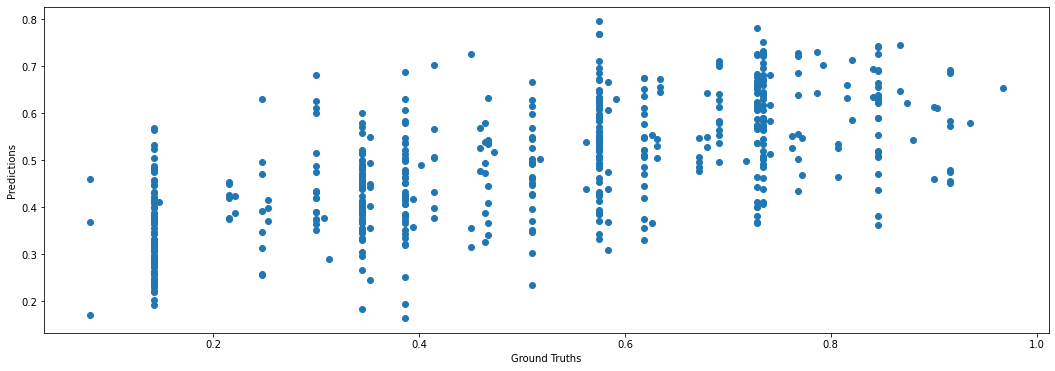

Error in callback <function _enable_matplotlib_integration.<locals>.configure_once at 0x7f00d2e32e50> (for post_run_cell):


ImportError: cannot import name 'configure_inline_support_orig' from 'matplotlib_inline.backend_inline' (/home/annina/anaconda3/envs/nlp/lib/python3.9/site-packages/matplotlib_inline/backend_inline.py)

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from math import sqrt
%matplotlib inline

book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
book_names = book_and_averaged_chunk_df["book_name"].values

book_and_averaged_chunk_df = book_and_averaged_chunk_df.drop(columns=["book_name"])
book_and_averaged_chunk_df = book_and_averaged_chunk_df[[column for column in book_and_averaged_chunk_df.columns if "average_sentence_embedding" not in column]]
best_features = book_and_averaged_chunk_df.columns[np.argwhere((rfe.ranking_ <= 10) == True).T[0]].tolist()
book_and_averaged_chunk_df = book_and_averaged_chunk_df[best_features]

df = book_and_averaged_chunk_df
df["y"] = np.array([labels[book_name] for book_name in book_names])
df["book_name"] = book_names

all_predictions = []
all_labels = []
train_mses = []
train_maes = []
train_r2s = []
validation_mses = []
validation_maes = []
validation_r2s = []

book_names_splitted = np.array_split(book_names, 10)
for index, split in enumerate(book_names_splitted):
    train_df = df[~df["book_name"].isin(split)]
    validation_df = df[df["book_name"].isin(split)]
    train_X = train_df.drop(columns=["y", "book_name"]).values
    train_y = train_df["y"].values.ravel()
    validation_X = validation_df.drop(columns=["y", "book_name"]).values
    validation_y = validation_df["y"].values.ravel()
    dtrain = xgboost.DMatrix(train_X, label=train_y)
    params = {"max_depth": 5, "learning_rate": 0.01, "colsample_bytree": 0.5, "min_child_weight": 6.0, "n_jobs": -1}
    model = xgboost.train(
        params,
        dtrain,
        num_boost_round=num_boost_round
    )

    train_books = deepcopy(train_df[["book_name", "y"]])
    train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
    validation_books = deepcopy(validation_df[["book_name", "y"]])
    validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))

    train_books = train_books.groupby("book_name").mean()
    validation_books = validation_books.groupby("book_name").mean()

    train_y = train_books["y"].tolist()
    train_yhat = train_books["yhat"].tolist()
    validation_y = validation_books["y"].tolist()
    validation_yhat = validation_books["yhat"].tolist()

    all_labels.extend(validation_y)
    all_predictions.extend(validation_yhat)

    train_mse = mean_squared_error(train_y, train_yhat)
    train_mae = mean_absolute_error(train_y, train_yhat)
    train_r2 = r2_score(train_y, train_yhat)
    validation_mse = mean_squared_error(validation_y, validation_yhat)
    validation_mae = mean_absolute_error(validation_y, validation_yhat)
    validation_r2 = r2_score(validation_y, validation_yhat)
    train_mses.append(train_mse)
    train_maes.append(train_mae)
    train_r2s.append(train_r2)
    validation_mses.append(validation_mse)
    validation_maes.append(validation_mae)
    validation_r2s.append(validation_r2)
    print(f"Fold: {index+1}, TrainMSE: {np.round(train_mse, 3)}, TrainMAE: {np.round(train_mae, 3)}, ValMSE: {np.round(validation_mse, 3)}, ValRMSE: {np.round(sqrt(validation_mse), 3)}, ValMAE: {np.round(validation_mae, 3)}, ValR2: {np.round(validation_r2, 3)}")
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

mean_train_mse = np.mean(train_mses)
mean_train_mae = np.mean(train_maes)
mean_train_r2 = np.mean(train_r2)
mean_validation_mse = np.mean(validation_mses)
mean_validation_mae = np.mean(validation_maes)
mean_validation_r2 = np.mean(validation_r2)


print("------")
print(f"Mean scores, TrainMSE: {np.round(mean_train_mse, 3)}, TrainMAE: {np.round(mean_train_mae, 3)}, ValMSE: {np.round(mean_validation_mse, 3)}, ValRMSE: {np.round(sqrt(mean_validation_mse), 3)}, ValMAE: {np.round(mean_validation_mae, 3)}, ValR2: {np.round(mean_validation_r2, 3)}")

plt.figure(figsize=(18, 6))
plt.scatter(all_labels, all_predictions)
plt.xlabel("Ground Truths")
plt.ylabel("Predictions")

plt.show();
